In [40]:
%matplotlib inline
#导入相关依赖库
from matplotlib import pyplot
import numpy as np
import os
import mindspore as ms
import mindspore.context as context
import mindspore.dataset as ds
import mindspore.dataset.transforms.c_transforms as C
import mindspore.dataset.vision.c_transforms as CV
from mindspore.nn.metrics import Accuracy
from mindspore import nn
from mindspore.train import Model
from mindspore.train.callback import  LossMonitor, CheckpointConfig, ModelCheckpoint
context.set_context(mode=context.GRAPH_MODE, device_target='CPU') 
from mindspore.train.callback import ModelCheckpoint,CheckpointConfig
from mindspore import load_checkpoint
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [41]:
DATA_DIR_TRAIN = "D:/DL/MNIST/MNIST/train" # 训练集信息
DATA_DIR_TEST = "D:/DL/MNIST/MNIST/test" # 测试集信息
DATA_DIR = "D:/DL/MNIST/MNIST"

In [42]:
def create_dataset(training=True, batch_size=32, resize=(32, 32),rescale=1/(255*0.3081), shift=-0.1307/0.3081, buffer_size=64):
    ds = ms.dataset.MnistDataset(DATA_DIR_TRAIN if training else DATA_DIR_TEST)
    

    resize_op = CV.Resize(resize)
    #rescale方法可以对数据集进行归一化和标准化操作，这里就是将像素值归一到0和1之间，shift参数可以让值域偏移至-0.5和0.5之间
    rescale_op = CV.Rescale(rescale, shift)
    hwc2chw_op = CV.HWC2CHW()
    
    # 利用map操作对原数据集进行调整
    ds = ds.map(input_columns="image", operations=[resize_op, rescale_op, hwc2chw_op])
    ds = ds.map(input_columns="label", operations=C.TypeCast(ms.int32))
    ds = ds.shuffle(buffer_size=buffer_size)
    ds = ds.batch(batch_size, drop_remainder=True)
    
    return ds

In [43]:
class LeNet5(nn.Cell):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, stride=1, pad_mode='valid')
        self.conv2 = nn.Conv2d(6, 16, 5, stride=1, pad_mode='valid')
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Dense(400, 120)
        self.fc2 = nn.Dense(120, 84)
        self.fc3 = nn.Dense(84, 10)

    def construct(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x

In [44]:
def train(lr=0.01, momentum=0.9, num_epochs=3):
    ds_train = create_dataset(training=True)
    net = LeNet5()
    loss = nn.loss.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
    opt = nn.Momentum(net.trainable_params(), lr, momentum)
    loss_cb = LossMonitor(per_print_times=ds_train.get_dataset_size())
    metrics = {
    'accuracy': nn.Accuracy(),
    'loss': nn.Loss(),
    'precision': nn.Precision(),
    'recall': nn.Recall(),
    'f1_score': nn.F1()
}
    model = Model(net, loss, opt, metrics=metrics)
    model.train(num_epochs, ds_train, callbacks=[loss_cb], dataset_sink_mode=False)
    return model
model = train()

epoch: 1 step: 1875, loss is 2.295088768005371
epoch: 2 step: 1875, loss is 0.468563973903656
epoch: 3 step: 1875, loss is 0.08443644642829895


In [45]:
def test(model):
    ds_eval = create_dataset(training=False)
    metrics = {
    'accuracy': nn.Accuracy(),
    'loss': nn.Loss(),
    'precision': nn.Precision(),
    'recall': nn.Recall(),
    'f1_score': nn.F1()
}
    metrics = model.eval(ds_eval, dataset_sink_mode=False)
    print('Metrics:', metrics)
test(model)

Metrics: {'accuracy': 0.9730568910256411, 'loss': 0.08062977199174035, 'precision': array([0.96996997, 0.98677249, 0.97705545, 0.95512195, 0.98871795,
       0.93461951, 0.97502601, 0.99487179, 0.96257796, 0.9825462 ]), 'recall': array([0.9897855 , 0.98677249, 0.99031008, 0.97123016, 0.98267074,
       0.97977528, 0.98115183, 0.94449854, 0.95463918, 0.94940476]), 'f1_score': array([0.97977755, 0.98677249, 0.98363811, 0.96310871, 0.98568507,
       0.95666484, 0.97807933, 0.96903097, 0.95859213, 0.96569122])}


In [46]:
cifar_ds = create_dataset(training=False, batch_size=32)
test_label = []
test_pred = []
for data in cifar_ds.create_dict_iterator(num_epochs=1, output_numpy=True):
    test_label.extend(data['label'])
    input_img = ms.Tensor(data['image'])
    output = model.predict(input_img)
    output = nn.Softmax(axis=1)(output)
    pred = output.asnumpy()
    pred = np.argmax(pred, axis=1)
    test_pred.extend(pred)

In [47]:
cm = confusion_matrix(test_label, test_pred,normalize='true')
cm

array([[9.90788127e-01, 0.00000000e+00, 0.00000000e+00, 1.02354145e-03,
        0.00000000e+00, 0.00000000e+00, 5.11770727e-03, 1.02354145e-03,
        2.04708291e-03, 0.00000000e+00],
       [0.00000000e+00, 9.86760812e-01, 1.76522507e-03, 1.76522507e-03,
        0.00000000e+00, 0.00000000e+00, 1.76522507e-03, 0.00000000e+00,
        7.94351280e-03, 0.00000000e+00],
       [3.87596899e-03, 9.68992248e-04, 9.90310078e-01, 2.90697674e-03,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.68992248e-04,
        9.68992248e-04, 0.00000000e+00],
       [9.92063492e-04, 0.00000000e+00, 1.98412698e-03, 9.71230159e-01,
        0.00000000e+00, 1.98412698e-02, 0.00000000e+00, 9.92063492e-04,
        3.96825397e-03, 9.92063492e-04],
       [1.01936799e-03, 1.01936799e-03, 0.00000000e+00, 2.03873598e-03,
        9.82670744e-01, 0.00000000e+00, 4.07747197e-03, 0.00000000e+00,
        3.05810398e-03, 6.11620795e-03],
       [2.24719101e-03, 0.00000000e+00, 0.00000000e+00, 5.61797753e-03,
   

<AxesSubplot:>

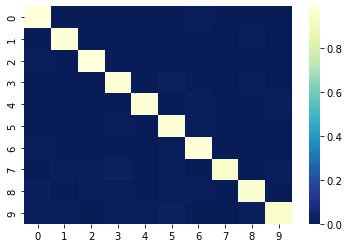

In [48]:
sns.heatmap(cm,cmap="YlGnBu_r")